# Module 3 Project Submission

- Student name: Tim Sennett
- Student pace: part time
- Scheduled project review date/time: Mon., February 3, 3:00 p.m. EST
- Instructor name: Abhineet Kulkarni
- Blog post URL: http://www.medium.com/@timsennett

For this Module 3 Final Project, I'm going to query the Northwind database to obtain the data needed to perform statistical analysis.  In this analysis, I'll perform a number of hypothesis tests to answer the following questions relevant to Northwind Traders' business:

1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2. Does the customer's region have a statistically significant effect on the average value of an order?
3. Does the supplier's region have a statistically significant effect on the average revenue made per product, per order?
4. Does North America generate significantly more revenue during Quarters 1 and 4 (Fall/Winter) than they do during Quarters 2 and 3 (Spring/Summer)?

## Schema Overview

Here's an overview of the database. It includes thirteen tables.

<img src="Northwind_ERD_updated.png">

In [121]:
ls

CONTRIBUTING.md                Northwind_small.sqlite
LICENSE.md                     README.md
Northwind-project.ipynb        adventureworks2008_schema.gif
Northwind_ERD.png              halfway-there.gif
Northwind_ERD_updated.png      module3_project_rubric.pdf


In [1]:
# Import SQLite, connect to the Northwind database, and create cursor.

import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import scipy.stats
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()

import warnings
warnings.filterwarnings('ignore')

Now that I've connected to the database and imported the necessary libraries, I'm going to define a couple of functions for measuring and visualizing effect size (the size of the difference between two groups under observation) that will end up coming in handy as I work through the process of conducting my hypethesis tests.

### Function for Cohen's d

In [3]:
def Cohen_d(group1, group2):
    '''Compute Cohen's d.
       
       group1: Series or NumPy array
       group2: Series or NumPy array

       returns a floating point number'''

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return abs(d)

In [4]:
def evaluate_PDF(rv, x=4):
    '''Input: a random variable object, standard deviation
    output : x and y values for the normal distribution
    '''
    
    # Identify the mean and standard deviation of random variable 
    mean = rv.mean()
    std = rv.std()

    # Use numpy to calculate evenly spaced numbers over the specified interval (4 sd) and generate 100 samples.
    xs = np.linspace(mean - x*std, mean + x*std, 100)
    
    # Calculate the peak of normal distribution i.e. probability density. 
    ys = rv.pdf(xs)

    return xs, ys # Return calculated values

In [5]:
def overlap_superiority(group1, group2, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    group1: scipy.stats rv object
    group2: scipy.stats rv object
    n: sample size
    """

    # Get a sample of size n from both groups
    group1_sample = group1.rvs(n)
    group2_sample = group2.rvs(n)
    
    # Identify the threshold between samples
    thresh = (group1.mean() + group2.mean()) / 2
    print(thresh)
    
    # Calculate no. of values above and below for group 1 and group 2 respectively
    above = sum(group1_sample < thresh)
    below = sum(group2_sample > thresh)
    
    # Calculate the overlap
    overlap = (above + below) / n
    
    # Calculate probability of superiority
    superiority = sum(x > y for x, y in zip(group1_sample, group2_sample)) / n

    return overlap, superiority

In [6]:
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    group1 = scipy.stats.norm(0, 1)
    group2 = scipy.stats.norm(cohen_d, 1)
    xs, ys = evaluate_PDF(group1)
    plt.fill_between(xs, ys, label='Control', color='#ff2289', alpha=0.7)

    xs, ys = evaluate_PDF(group2)
    plt.fill_between(xs, ys, label='Experimental', color='#376cb0', alpha=0.7)
    plt.legend()
    
    o, s = overlap_superiority(group1, group2)
    print('overlap', o)
    print('superiority', s)

Now let's get to tackling these questions, starting with #1.

## Question 1:

***Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?***

- **Null Hypothesis**: Products priced at a discount are purchased in equal quantity per order as products not purchased at a discount.

- **Alternative Hypothesis**: Products priced at a discount are purchased in greater quantity per order as products not purchased at a discount.

For this one-tailed test, **an alpha level of 0.025 will be used**.

The first step toward answering this question is to extract the appropriate data, namely, Quantity and Discount.

Then, I'll create control and experimental groups, with the former including the quantity of each product per order when there is no discount, and the latter containing the quantity of each product per order when there is a discount.

In [7]:
cur.execute("""SELECT Quantity, Discount
               FROM OrderDetail;""")
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [8]:
# Making two subsets of the data: no discount, and discount

no_discount_df = df1[df1['Discount'] == 0]['Quantity']
discount_df = df1[df1['Discount'] != 0]['Quantity']

In [9]:
no_discount_df.head(8)

0     12
1     10
2      5
3      9
4     40
5     10
10    20
13    40
Name: Quantity, dtype: int64

In [10]:
discount_df.head(8)

6     35
7     15
8      6
9     15
11    40
12    25
17    15
18    21
Name: Quantity, dtype: int64

In [11]:
print("There were {} instances of a product being sold at discount.".format(len(discount_df)))
print("There were {} instances of a product being sold at no discount.\n".format(len(no_discount_df)))
print("The company has sold its products at {} different discount levels."
      .format(df1.Discount.nunique() - 1)) # subtract 1 because "discount" of 0.0 shouldn't be included in count

There were 838 instances of a product being sold at discount.
There were 1317 instances of a product being sold at no discount.

The company has sold its products at 10 different discount levels.


Before proceeding further, let's get a glimpse of how discount may impact the quantity of products ordered.

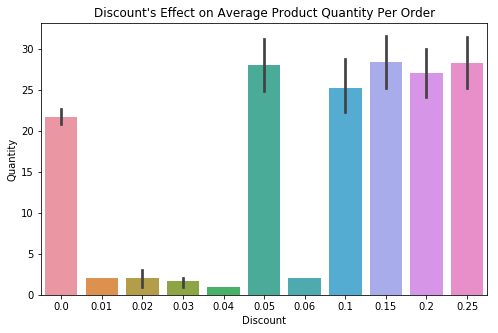

In [12]:
plt.figure(figsize=(8,5))
sns.barplot(df1.Discount, df1.Quantity)
plt.title("Discount's Effect on Average Product Quantity Per Order")
plt.show()

- Evidently, products discounted at 0.05 or more tend to be ordered in much greater quantity than products discounted at less than 0.05. (The lone exception is the 0.06 discount level.)

- The most heavily applied discount levels are 0.05, 0.1, 0.15, 0.2 and 0.25.

- Non-discounted products are still ordered in greater quantity than lightly discounted (0.01–0.04) products.

Now that I'm looking at this, I wonder how many times the .01, .02, .03, .04 and .06 discounts have been applied anyway?

In [13]:
# Create array of discount levels

discount_levels = df1['Discount'].unique()
discount_levels.sort()

print('Discount levels:', discount_levels)

Discount levels: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


In [14]:
# Populate a dictionary wherein each discount level is a key
# and the dict values are comprised of the index, product quantity per order,
# and corresponding discount level

levels = {}
for i in discount_levels:
    levels[i] = df1[df1['Discount']==i]

In [15]:
# sanity check

levels.keys(), levels.values()

(dict_keys([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.15, 0.2, 0.25]),
 dict_values([      Quantity  Discount
 0           12       0.0
 1           10       0.0
 2            5       0.0
 3            9       0.0
 4           40       0.0
 5           10       0.0
 10          20       0.0
 13          40       0.0
 14          20       0.0
 15          42       0.0
 16          40       0.0
 19          21       0.0
 20          20       0.0
 21          35       0.0
 22          25       0.0
 23          30       0.0
 24          15       0.0
 25          12       0.0
 26          25       0.0
 27           6       0.0
 28          15       0.0
 32          10       0.0
 33           1       0.0
 35          50       0.0
 38          20       0.0
 39          20       0.0
 41          15       0.0
 42           2       0.0
 44          28       0.0
 47          35       0.0
 ...        ...       ...
 2088         4       0.0
 2089        10       0.0
 2090        15       0.0


In [16]:
# Create new dataframe that tells me the number of instances each discount level has
# been applied, and the average product quantity per order at each discount level

discount_levels_df = pd.DataFrame(columns=['Discount Level','Product Orders','Avg. Product Quantity per Order'])

for i in levels.keys():
    discount_levels_df = discount_levels_df.append({'Discount Level':i,'Product Orders':len(levels[i]),
                                                    'Avg. Product Quantity per Order':levels[i]['Quantity'].mean()},
                                                    ignore_index=True)

discount_levels_df

,Discount Level,Product Orders,Avg. Product Quantity per Order
0,0.00,1317.0,21.715262
1,0.01,1.0,2.000000
2,0.02,2.0,2.000000
3,0.03,3.0,1.666667
4,0.04,1.0,1.000000
5,0.05,185.0,28.010811
6,0.06,1.0,2.000000
7,0.10,173.0,25.236994
8,0.15,157.0,28.382166
9,0.20,161.0,27.024845


The .01, .02, .03, .04 and .06 discounts have been applied so seldom (on only 1–3 occassions each). And in the rare occasions that there are applied, the quantities have been quite small. It makes a lot of sense to drop those observations from the data.

In [17]:
uncommon_discounts = [0.01, 0.02, 0.03, 0.04, 0.06]

for i in uncommon_discounts:
    df1 = df1[df1.Discount != i]
    
df1.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 ])

Now, with those lesser used discount levels removed from the data, I'll once again create my control and experimental groups.

In [18]:
no_discount_df = df1[df1['Discount'] == 0]['Quantity'] # control
discount_df = df1[df1['Discount'] != 0]['Quantity']    # experimental

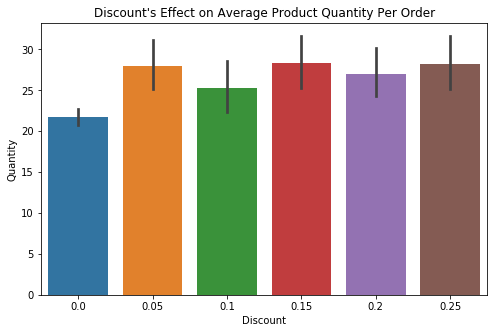

In [19]:
plt.figure(figsize=(8,5))
sns.barplot(df1.Discount, df1.Quantity)
plt.title("Discount's Effect on Average Product Quantity Per Order")
plt.show()

Because all evidence points to discounts *increasing* the quantity of products in an order (see above bar graph, where every level of discount results in greater product quantities per order than when there is no discount), **I'll perform a one-tailed Welch's t-test** to determine whether or not I can reject the null hypothesis. (Welch's was chosen to correct for the sizable difference in sample size.)

In [24]:
# Average order quantity with and without discounts

discount_df.mean(), no_discount_df.mean()

(27.35421686746988, 21.715261958997722)

In [20]:
print(f"The size of the 'non-discount' sample is {len(no_discount_df)}.")
print(f"The size of the 'discount' samples is {len(discount_df)}.")

The size of the 'non-discount' sample is 1317.
The size of the 'discount' samples is 830.


In [549]:
t_stat, p = stats.ttest_ind(no_discount_df, discount_df, equal_var=False) # False indicates test is Welch's

# Calculate effect size
d = Cohen_d(no_discount_df, discount_df)

# Calculate statistical power, i.e. the probability of rejecting null hypothesis given that it is false
power = power_analysis.solve_power(effect_size=d, nobs1=len(no_discount_df), alpha=.025)

print(f'P Value is {p}. Therefore, reject null hypothesis.') if p < 0.025 else print('Failed to reject Null Hypothesis.')
print(f't_stat is {t_stat}.')
print("Cohen's d:", d)
print("Statistical power:", power)

P Value is 1.0051255540843165e-10. Therefore, reject null hypothesis.
t_stat is -6.511219067380875.
Cohen's d: 0.29970787209408895
Statistical power: 1.0


Because the p-value falls below the stated alpha level of 0.025, **I can reject the null hypothesis**. As expected, there all but assuredly is a statistically significant difference between the quantity of products ordered with and without discounts. That being said, **the size of the difference (effect size) is small to moderate**.

Now the question is: at what level of discount do we start to see this statistically significant difference? 0.05? 0.20? Let's find out!

To answer that, it's necessary to take a closer look at Northwind's five most popular discount levels. I'm going to create a DataFrame, and then execute a for loop that will iterate through a list of the five discount levels, run a t-test on an experimental group from each of those discount levels and the non-discount control group, and then populate the newly created DataFrame with the p-values, Cohen's d, and a determination of whether or not to reject the null hypothesis at each respective discount level.

For the purposes of avoiding the Multi Comparisons Problem, I'm going to employ the "Bonferroni correction" by dividing my 𝛼 (0.025) by the number of comparisons I'm making (5) to set a new, adjusted threshold for rejecting the null hypothesis. This ends up being 0.005, and implementing this lower threshold dramatically reduces the cumulative likelihood of any Type I Errors occuring.

In [486]:
alpha = 0.025
num_comparisons = 5

new_alpha = alpha / num_comparisons
new_alpha

0.005

In [571]:
# Create new dataframe in which to load the results
discount_significance_df = pd.DataFrame(columns=['Discount', 'P Value', 'Null Hypothesis',
                                                 "Effect Size", "Statistical Power"], index=None)

common_discounts = [0.05, 0.10, 0.15, 0.20, 0.25]

for i in common_discounts:
    experimental = df1[df1['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(no_discount_df, experimental, equal_var=False)  # False indicates Welch's t-test
    d = Cohen_d(no_discount_df, experimental)
    power = power_analysis.solve_power(effect_size=d, nobs1=len(no_discount_df), alpha=.005)
    discount_significance_df = discount_significance_df.append({'Discount' : i,
                                                                'P Value' : p,
                                                                'Null Hypothesis' : 'Reject' if p < 0.005
                                                                 else 'Failed', "Effect Size" : d,
                                                                'Statistical Power' : power},
                                                                 ignore_index=True)    

discount_significance_df

,Discount,P Value,Null Hypothesis,Effect Size,Statistical Power
0,0.05,0.000272,Reject,0.346877,1.000000
1,0.10,0.037456,Failed,0.195942,0.986699
2,0.15,0.000172,Reject,0.372404,1.000000
3,0.20,0.000811,Reject,0.300712,1.000000
4,0.25,0.000159,Reject,0.366593,1.000000


At all but one of the most commonly applied discount levels, there remains (despite a much lower 𝛼) a statistically significant difference in the quantity of products ordered as compared to when there is no applied discount.

So, given the available data, **I can confidently conclude that discounts generally do result in higher product quantities per order, with the exception of the .10 discount.**

Of course, by limiting my tolerance of Type I Errors (by setting a lower alpha), I necessarily increased my tolerance of Type II Errors (False Negatives). Still, the results suggest that even on highly unlikely chance that a Type II Error occured, the 0.10 discount level would have been less effective at driving up quantity than other commonly used discount levels. This is known by looking at the Cohen's d for that discount level (0.195942), which reveals that discounts of 10% have only a small effect on product quantity per order, if any. The other discount levels, by contrast, have closer to a moderate effect.

0.097971
overlap 1.107
superiority 0.432


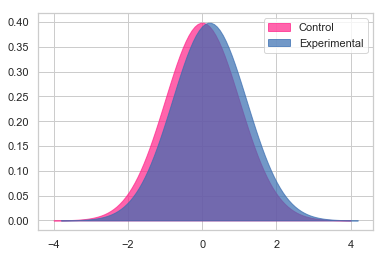

In [526]:
# This plot provides a visual of the effect size of 10% discounts
# Try with the effect sizes of other discount levels to see how they compare

plot_pdfs(cohen_d=0.195942)

## Question 2:

***Does the customer's region have a statistically significant effect on the total value of an order?***

- **Null Hypothesis**: The customer's region does not significantly effect the total value of an order.
- **Alternative Hypothesis**: The customer's region does significantly effect the total value of an order.

For this experiment, **an alpha level of 0.05 will be used**.

The first step toward answering this question is to extract the appropriate data, namely, Region, OrderID, Quantity, UnitPrice and Discount. To do this I joined the Customer, OrderDetail and Order tables.

In [25]:
cur.execute("""SELECT Region, OrderID, Quantity, UnitPrice, Discount
               FROM Customer c
               JOIN 'Order' o
               ON c.id = o.CustomerID
               JOIN OrderDetail d
               ON o.id = d.OrderID;""")
df2 = pd.DataFrame(cur.fetchall())
df2.columns = [x[0] for x in cur.description]
df2.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


The above query gets me part of the way there. Now I'll calculate the total value of each order, taking into account the Quantity, UnitPrice and Discount of each product per Order. Then I'll group the data by Region.

In [26]:
# Create new feature for TotalOrderPrice
df2['TotalOrderPrice'] = df2.Quantity * df2.UnitPrice * (1 - df2.Discount)

# Drop the now unneeded features
df2.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

# Sum the price figures of each individual order
df2 = df2.groupby(['Region', 'OrderId'])['TotalOrderPrice'].sum().reset_index()

# Drop the now unneeded OrderID feature
df2.drop('OrderId', axis=1, inplace=True)

In [27]:
df2.head()

,Region,TotalOrderPrice
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


Now that the data is queried and formatted, let me get a look at how customer region might impact average order values.

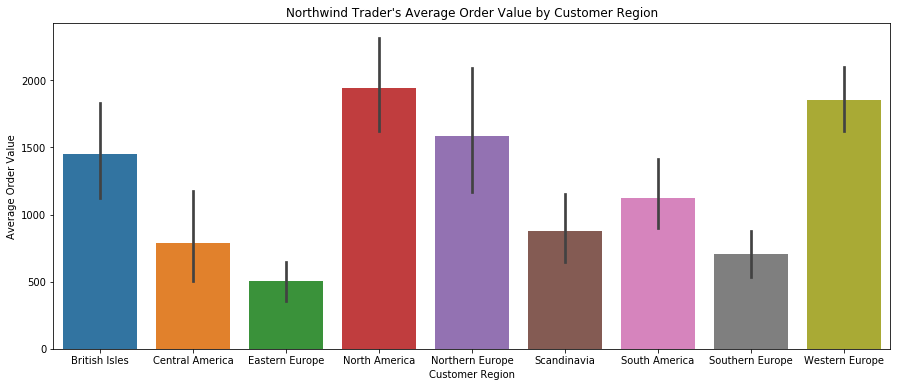

In [28]:
plt.figure(figsize=(15,6))
sns.barplot(df2.Region, df2.TotalOrderPrice)
plt.xlabel('Customer Region')
plt.ylabel('Average Order Value')
plt.title("Northwind Trader's Average Order Value by Customer Region")
plt.show()

In [29]:
df2.groupby('Region').count()

,TotalOrderPrice
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


The table above shows that the regions generating the most orders for Northwind are Western Europe (272), followed by North America (152) and South America (127), respectively. However, when measuring by average order value (see above bar graph), Northwind's best customers are coming out of North America, Western Europe and Northern Europe, respectively. Hopefully the findings of my hypothesis test back this up.

Before moving ahead, though, I ought to deal with Central America, Eastern Europe, and Scandinavia. Nothing against those places, but if I'm going to conduct an ANOVA test, as I plan to do, **I have to satisfy the assumption of homogeneity of variance**. In other words, ANOVA assumes the variance among groups should be approximately equal. This assumption is threatened by the awfully low sample sizes coming out of those three regions (relative to the other seven regions).

To make this work, I'll combine each of these three regions with another region, based on geographical proximity: Eastern Europe with Southern Europe, Scandanavia with Northern Europe, and Central America with South America.

In [30]:
df2.loc[(df2.Region == 'Eastern Europe') | (df2.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'
df2.loc[(df2.Region == 'Scandinavia') | (df2.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'
df2.loc[(df2.Region == 'Central America') | (df2.Region == 'South America'),'Region'] = 'South and Central America'

In [31]:
df2.groupby('Region').count()

,TotalOrderPrice
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


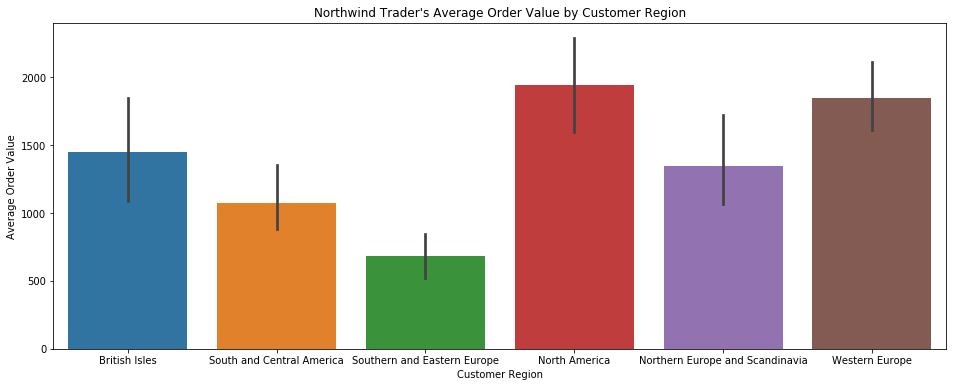

In [34]:
# Updated chart to reflect combined regions

plt.figure(figsize=(16,6))
sns.barplot(df2.Region, df2.TotalOrderPrice)
plt.xlabel('Customer Region')
plt.ylabel('Average Order Value')
plt.title("Northwind Trader's Average Order Value by Customer Region")
plt.show()

With that taken care of, let me now check to see whether the data satisfies another key assumption of ANOVA: normality.

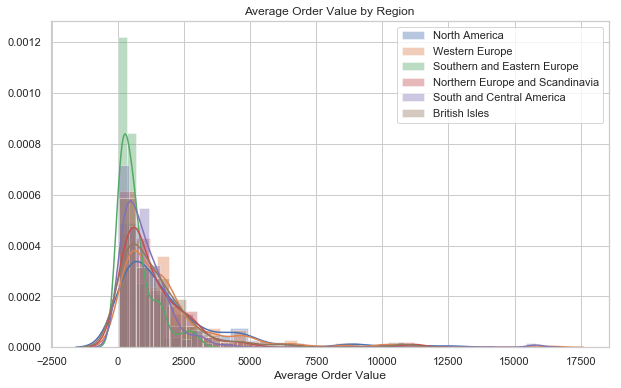

In [497]:
plt.figure(figsize=(10, 6))
for region in set(df2.Region):
    region_group = df2.loc[df2['Region'] == region]
    sns.distplot(region_group['TotalOrderPrice'], label=region)
    plt.legend()
    plt.title('Average Order Value by Region')
    plt.xlabel('Average Order Value')

Clearly, the data is positively skewed and does not follow a normal distribution (i.e., bell curve). I can remedy this by log transforming the data, making it better suited for use in my upcoming ANOVA test.

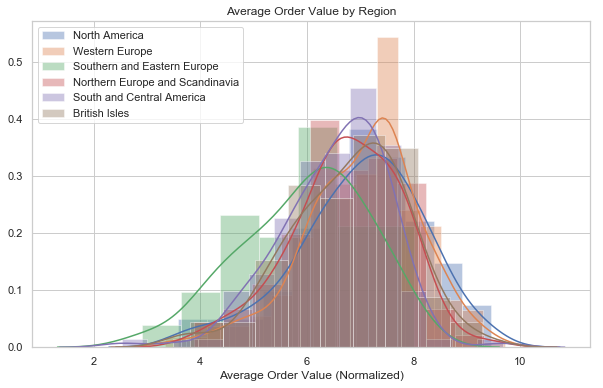

In [498]:
# copy the non-normal data
df2_log = df2.copy()

# log transform the copied data
df2_log['TotalOrderPrice'] = np.log(df2['TotalOrderPrice'])

# plot the distributions for the log-transformed data
plt.figure(figsize=(10,6))
for region in set(df2_log.Region):
    region_group = df2_log.loc[df2_log['Region'] == region]
    sns.distplot(region_group['TotalOrderPrice'], label=region)
    plt.legend()
    plt.title('Average Order Value by Region')
    plt.xlabel('Average Order Value (Normalized)')

Alright, now that I've worked to satisfy normality and homogeneity of variance, it's safe for me to perform an ANOVA test on the data. Let's see whether or not I can reject my null hypothesis! For this, I'll conduct an ANOVA test, which is equivalent to a 2-sided t-test when comparing two groups.

In [499]:
formula = "TotalOrderPrice ~ C(Region)"
lm = ols(formula, df2_log).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq     df          F        PR(>F)
C(Region)   77.999547    5.0  13.032374  3.285724e-12
Residual   951.624641  795.0        NaN           NaN


Looking to the far right of this table, I see clearly that Region is an influential factor. Or, better put, it's highly improbable that Region is *not* a statistically significant factor in determining the total price of an order. A value less than my 𝛼 (0.05), as seen here, indicates that **I can reject the null hypothesis**. The data strongly suggests that customer region does effect the average order value. This conclusion is supported by an effect size (f) of 13.032.

## Question 3:

***Does the supplier's region have a statistically significant effect on the per-order revenues from a given product?***

- **Null Hypothesis**: The per-order revenue from a given product is uneffected by its supplier's region.
- **Alternative Hypothesis**: The per-order revenue from a given product is significantly effected by its supplier's region.

For this experiment, **an alpha level of 0.05 will be used**.

We're confident about where the best customers are located. But what about the best suppliers? The first step toward answering this question is to extract the appropriate data, namely, Supplier Region, Id, UnitPrice, Quantity and Discount. To do this I joined the Product, Supplier, and OrderDetail tables.

In [55]:
cur.execute("""SELECT Region, od.Id, od.UnitPrice, Quantity, Discount
               FROM Supplier s
               JOIN Product p
               ON s.Id = p.SupplierId
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               ;""")
df3 = pd.DataFrame(cur.fetchall())
df3.columns = [x[0] for x in cur.description]
df3.head()

,Region,Id,UnitPrice,Quantity,Discount
0,Southern Europe,10248/11,14.0,12,0.0
1,South-East Asia,10248/42,9.8,10,0.0
2,Southern Europe,10248/72,34.8,5,0.0
3,Eastern Asia,10249/14,18.6,9,0.0
4,NSW,10249/51,42.4,40,0.0


In [56]:
df3.Region.unique()

array(['Southern Europe', 'South-East Asia', 'Eastern Asia', 'NSW',
       'North America', 'Northern Europe', 'British Isles', 'Scandinavia',
       'Western Europe', 'South America', 'Victoria'], dtype=object)

Now I'll calculate the total revenue made on each product per order.

In [57]:
# Create new feature for TotalOrderPrice
df3['RevenuePerProductPerOrder'] = df3.Quantity * df3.UnitPrice * (1 - df3.Discount)

# Drop the now unneeded features
df3.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

# Sum the total amount of money spent on each product per order
df3 = df3.groupby(['Region', 'Id'])['RevenuePerProductPerOrder'].sum().reset_index()

# Drop the now unneeded Id feature
df3.drop('Id', axis=1, inplace=True)

In [58]:
df3.head()

,Region,RevenuePerProductPerOrder
0,British Isles,2462.4
1,British Isles,304.0
2,British Isles,608.0
3,British Isles,80.0
4,British Isles,160.0


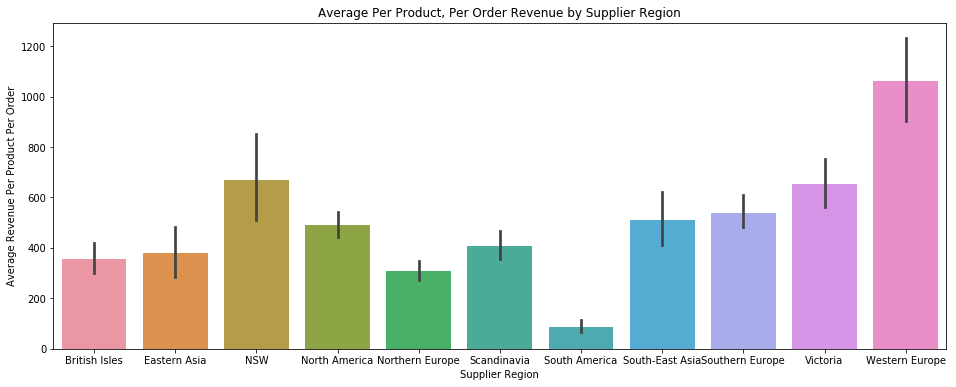

In [59]:
plt.figure(figsize=(16,6))
sns.barplot(df3.Region, df3.RevenuePerProductPerOrder)
plt.xlabel('Supplier Region')
plt.ylabel('Average Revenue Per Product Per Order')
plt.title("Average Per Product, Per Order Revenue by Supplier Region")
plt.show()

It sure looks like the most revenue (per product per order) is coming from Western Europe, followed by New South Wales (in southeastern Australia) and Victoria (also in southeastern Australia). South America generates the least revenue per product per order.

Let's see if an ANOVA test will support the alternative hypothesis that the amount spent per product per order is significantly effected by the supplier's region. I'll conduct one in a similar fashion as to how it was done in answering Question 2.

But first, as I did before, let me get a look at how many times each supplier region has handled a product-order.

In [60]:
df3.groupby('Region').count()

,RevenuePerProductPerOrder
Region,
British Isles,220
Eastern Asia,119
NSW,98
North America,418
Northern Europe,153
Scandinavia,175
South America,51
South-East Asia,82
Southern Europe,229


It sure looks like products from Western Europe are showing up in Northwind's orders more often than those from any other world region. They've got the goods! North America is a close second by this measure.

Near the bottom of the pack here, somewhat surprisingly, is New South Wales. It's surprisingly, because, as seen earlier, NSW generates the second-most revenue per product per order of all eleven supplier-regions (suggesting perhaps, that while products from NSW don't generate many orders, the products that they do sell are pretty expensive!).

Maybe this would be a good time to combine our two Australian states (NSW and Victoria). It's a sensible move geographically, and it helps to reduce any dramatic differences in variance and sample size among our regions.

While I'm at it, I'll also maintain some continuity with our work from the previous question by combining Northern Europe and Scandinavia.

In [61]:
df3.loc[(df3.Region == 'NSW') | (df3.Region == 'Victoria'),'Region'] = 'Australia'
df3.loc[(df3.Region == 'Northern Europe') | (df3.Region == 'Scandinavia'),'Region'] = 'North. Europe & Scandinavia'

In [62]:
df3.groupby('Region').count()

,RevenuePerProductPerOrder
Region,
Australia,261
British Isles,220
Eastern Asia,119
North America,418
North. Europe & Scandinavia,328
South America,51
South-East Asia,82
Southern Europe,229
Western Europe,447


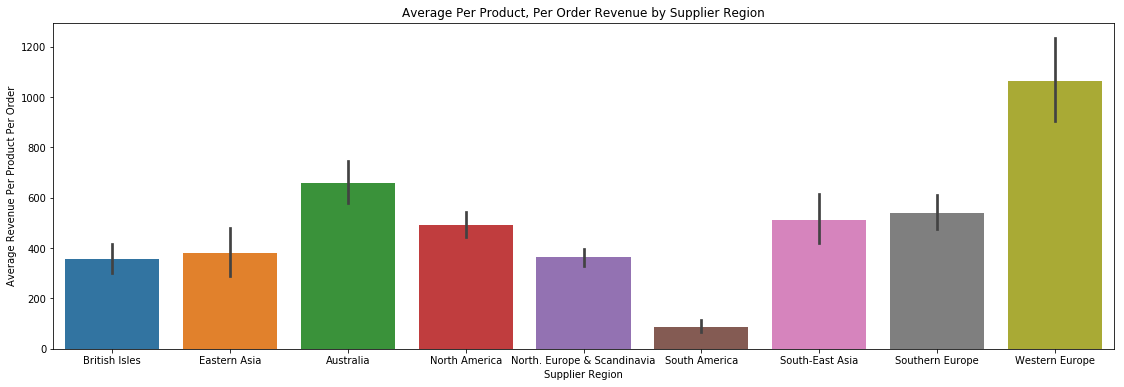

In [63]:
# updated chart to reflect combined regions

plt.figure(figsize=(19,6))
sns.barplot(df3.Region, df3.RevenuePerProductPerOrder)
plt.xlabel('Supplier Region')
plt.ylabel('Average Revenue Per Product Per Order')
plt.title("Average Per Product, Per Order Revenue by Supplier Region")
plt.show()

With that taken care of, let me now check to see whether the data satisfies another key assumption of ANOVA: normality.

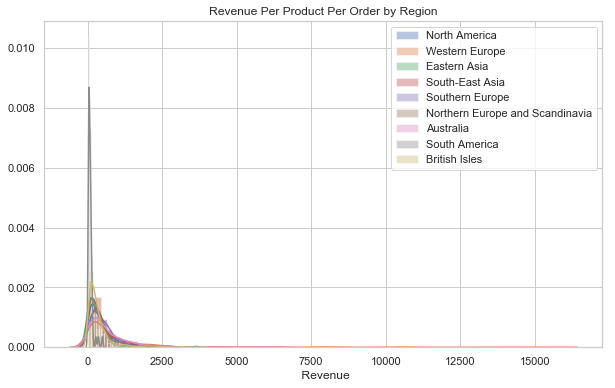

In [904]:
plt.figure(figsize=(10,6))
for region in set(df3.Region):
    region_group = df3.loc[df3['Region'] == region]
    sns.distplot(region_group['RevenuePerProductPerOrder'], label=region)
    plt.legend()
    plt.title('Revenue Per Product Per Order by Region')
    plt.xlabel(' Revenue')

Clearly, the data is positively skewed, and does not follow a normal distribution (i.e., bell curve). It has a mighty long tail moving to the right. I can remedy this by log transforming the data, making it better suited for use in my upcoming ANOVA test.

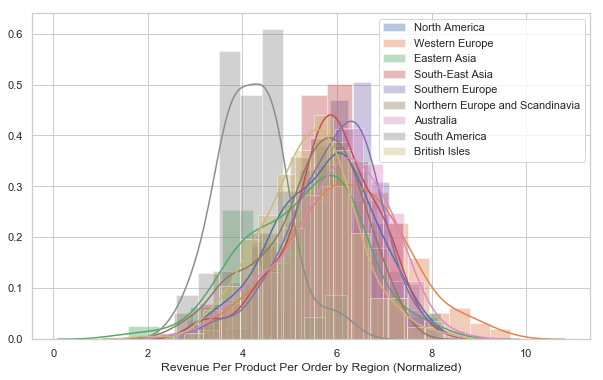

In [905]:
# copy the non-normal data
df3_log = df3.copy()

# log transform the copied data
df3_log['RevenuePerProductPerOrder'] = np.log(df3['RevenuePerProductPerOrder'])

# plot the distributions for the log-transformed data
plt.figure(figsize=(10,6))
for region in set(df3_log.Region):
    region_group = df3_log.loc[df3_log['Region'] == region]
    sns.distplot(region_group['RevenuePerProductPerOrder'], label=region)
    plt.legend()
    plt.xlabel('Revenue Per Product Per Order by Region (Normalized)')

These pre- and post-transformation graphs are indicating to me that the revenue data from South American products is very abnormal. So much so that I'm afraid it will adversely effect the performance of my ANOVA test. And because there are only 51 instances of South American products appearing in any orders (very low compared to other regions), I don't mind re-tracing my steps a little and removing South America from the data completely.

In [906]:
df3 = df3[df3['Region'] != 'South America']

In [907]:
df3.Region.unique()

array(['British Isles', 'Eastern Asia', 'Australia', 'North America',
       'Northern Europe and Scandinavia', 'South-East Asia',
       'Southern Europe', 'Western Europe'], dtype=object)

Now that I've settled on these eight regions, I'll again log-transform the data in order to achieve normality.

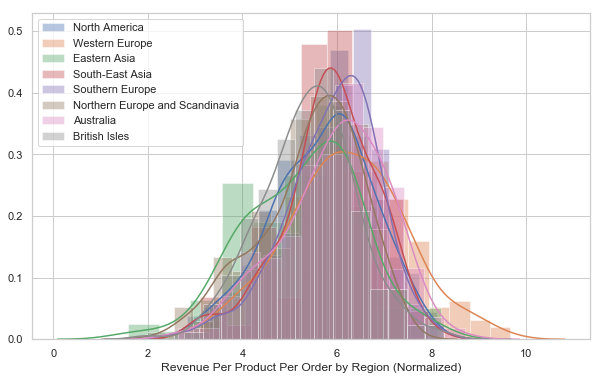

In [908]:
# copy the non-normal data
df3_log = df3.copy()

# log transform the copied data
df3_log['RevenuePerProductPerOrder'] = np.log(df3['RevenuePerProductPerOrder'])

# plot the distributions for the log-transformed data
plt.figure(figsize=(10,6))
for region in set(df3_log.Region):
    region_group = df3_log.loc[df3_log['Region'] == region]
    sns.distplot(region_group['RevenuePerProductPerOrder'], label=region)
    plt.legend()
    plt.xlabel('Revenue Per Product Per Order by Region (Normalized)')

Alright, now that I've worked to satisfy normality and homogeneity of variance, it's safe for me to perform an ANOVA test on the data. Let's see whether or not I can reject my null hypothesis!

In [909]:
formula = "RevenuePerProductPerOrder ~ C(Region)"
lm = ols(formula, df3_log).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq      df          F        PR(>F)
C(Region)   184.704659     7.0  21.575373  2.796495e-28
Residual   2563.378696  2096.0        NaN           NaN


Looking to the far right of this table, I see clearly that Supplier Region is an influential factor in the revenue per product per order. Or, better put, it's highly improbable that Supplier Region is *not* a statistically significant factor in determining the revenue per product per order. A value less than my 𝛼 (0.05), as seen here, indicates that **I can reject the null hypothesis**. This conclusion is supported by an effect size (f) of 21.575.

## Question 4:

**Does North America generate significantly more or less revenue during Quarters 1 and 4 (Fall/Winter) than they do during Quarters 2 and 3 (Spring/Summer)?**

- **Null Hypothesis**: North America does not generate significantly more or less revenue than 1784.19 during Quarters 1 and 4.
- **Alternative Hypothesis**: North America generates significantly more or less revenue than 1784.19 during Quarters 1 and 4.

Note: 1784.19 is the mean order price for all orders placed in Quarters 2 and 3.

For this experiment, **an alpha level of 0.05 will be used**.

The first step toward answering this question is to extract the appropriate data, namely, OrderDate, Region, OrderID, Quantity, UnitPrice and Discount. To do this I'll join the Customer, OrderDetail and Order tables, while extracting the month from the OrderDate.

In [72]:
cur.execute("""SELECT Region, strftime('%m', OrderDate) AS 'OrderMonth',
                      OrderID, Quantity, UnitPrice, Discount
               FROM Customer c
               JOIN 'Order' o
               ON c.Id = o.CustomerId
               JOIN OrderDetail od
               ON o.id = od.OrderID
               WHERE Region IS 'North America';""")
df4 = pd.DataFrame(cur.fetchall())
df4.columns = [x[0] for x in cur.description]
df4.head()

,Region,OrderMonth,OrderId,Quantity,UnitPrice,Discount
0,North America,07,10262,12,17.0,0.20
1,North America,07,10262,15,24.0,0.00
2,North America,07,10262,2,30.4,0.00
3,North America,07,10269,60,2.0,0.05
4,North America,07,10269,20,27.8,0.05


As in Question 2, I'm going to use existing features to calculate the total value of each order. Then I'll group the data by OrderMonth.

In [73]:
# Create new feature for TotalOrderPrice
df4['TotalOrderPrice'] = df4.Quantity * df4.UnitPrice * (1 - df4.Discount)

# Drop the now unneeded features
df4.drop(['Region', 'Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

# Sum the price figures of each individual order
df4 = df4.groupby(['OrderMonth', 'OrderId'])['TotalOrderPrice'].sum().reset_index()

# Drop the now unneeded OrderID feature
df4.drop('OrderId', axis=1, inplace=True)

In [74]:
df4.head()

,OrderMonth,TotalOrderPrice
0,01,3868.60
1,01,802.00
2,01,966.80
3,01,102.40
4,01,9194.56


Now I'll get a preview of the data by plotting a bar graph, to give me some early indications as to what I might find in my upcoming hypothesis test.

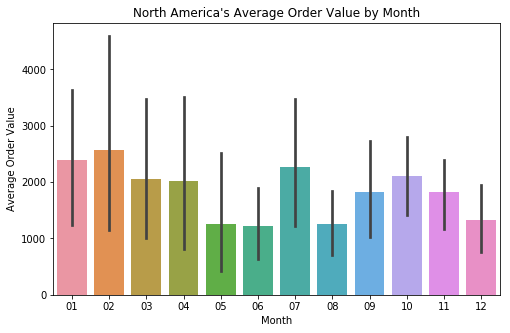

In [75]:
plt.figure(figsize=(8,5))
sns.barplot(df4.OrderMonth, df4.TotalOrderPrice)
plt.xlabel('Month')
plt.ylabel('Average Order Value')
plt.title("North America's Average Order Value by Month")
plt.show()

There's no clear difference or pattern in Total Order Price from month to month, much less quarter to quarter.

Let's see if the hypothesis test agrees. And because I'm checking for statistically significant differences on the low *and* the high end, I'll use a two-tailed t-test.

But first, I'll set up my control and experimental groups, with the former containing revenue data from Quarters 2 and 3, and the latter containing revenue data from Quarters 1 and 4.

In [76]:
Q23 = df4[df4['OrderMonth'] != '01']
Q23 = Q23[Q23['OrderMonth'] != '02']
Q23 = Q23[Q23['OrderMonth'] != '03']
Q23 = Q23[Q23['OrderMonth'] != '10']
Q23 = Q23[Q23['OrderMonth'] != '11']
Q23 = Q23[Q23['OrderMonth'] != '12']

Q14 = df4[df4['OrderMonth'] != '04']
Q14 = Q14[Q14['OrderMonth'] != '05']
Q14 = Q14[Q14['OrderMonth'] != '06']
Q14 = Q14[Q14['OrderMonth'] != '07']
Q14 = Q14[Q14['OrderMonth'] != '08']
Q14 = Q14[Q14['OrderMonth'] != '09']

In [77]:
Q23 = Q23['TotalOrderPrice'] # control group (Quarters 2, 3)
Q14 = Q14['TotalOrderPrice'] # experimental group (Quarters 1, 4)

In [78]:
Q14.mean()

2083.9971951219513

In [70]:
# perform two-tailed Welch's t-test
t_stat, p = stats.ttest_ind(Q23, Q14, equal_var=False) # False indicates Welch's t-test

# Calculate effect size
d = Cohen_d(Q23, Q14)

# Calculate statistical power, i.e. the probability of rejecting null hypothesis given that it is false
power = power = power_analysis.solve_power(effect_size=d, nobs1=len(Q23), alpha=.05)

print(f'P Value is {p}. Reject the Null Hypothesis.') if p < 0.05 else print(f'P Value is {p}. Failed to reject Null Hypothesis.')
print("Cohen's d:", d) if p < 0.05 else None
print("Statistical power:", power) if p < 0.05 else None

P Value is 0.405685361601112. Failed to reject Null Hypothesis.


With a P-value of 0.40 (well above my alpha level of 0.05) I have failed to reject the null hypothesis. There does not appear to be a statistically significant difference in revenue between Quarters 1 and 4, and Quarters 2 and 3. Good to know!

## Conclusion:

- Discounts generally result in higher product quantities per order (with the possible exception of the .10 discount).
- Customer region plays a significant role in average order value.
- Supplier region plays an even more significant role in average order value.
- North Americans typically spend just as much in Quarters 1 and 4 as they do in Quarters 2 and 3.

## Future work:

- Is there a certain subset of the customer population for which discounts are more effective than others?
- Are there any particular products that customers are more motivated to buy at discount than others?
- Given the relatively low activity, as well as low yields, does it make sense to continue selling products from South America?
- Does month of the year have a significant impact on sales when broken down geographically? (i.e., Does the southern hemisphere spend more during certain parts of year than the northern hemisphere?)